In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import torch
import torch.nn as nn
from PIL import Image
from scipy import ndimage
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
import pytorch_lightning as pl

%matplotlib inline
np.random.seed(1)

In [2]:
# Loading the data (signs)
def get_imgs_labels(h5_file_path):
    f = h5py.File(h5_file_path, "r")
    ds_keys = [key for key in f.keys()]
    imgs = np.array(f[ds_keys[1]])    
    labels = np.array(f[ds_keys[2]])
    list_classes = np.array(f[ds_keys[0]])
    imgs = np.transpose(imgs, (0, 3, 1, 2))
    return imgs, labels, list_classes

train_x, train_y, train_classes = get_imgs_labels("./datasets/train_signs.h5")
test_x, test_y, test_classes = get_imgs_labels("./datasets/test_signs.h5")
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(1080, 3, 64, 64) (1080,)
(120, 3, 64, 64) (120,)


In [3]:
type(train_x[0][0])

numpy.ndarray

In [4]:
import timm

#timm.list_models(filter="efficient*")#

In [5]:
# CONSTANTS
class Config:
    NUM_FOLDS = 5
    NUM_CLASSES = 6
    BATCH_SIZE = 64
    NUM_WORKERS = 4
    NUM_EPOCHS = 5
    TRAIN_IMG_MEAN = [0.485, 0.456, 0.406]
    TRAIN_IMG_STD = [0.229, 0.224, 0.225]
    UNFREEZE_EPOCH_NO = 2
    PRECISION = 16

class TransformationType:
    TORCHVISION = "torchvision"
    ALB = "albumentations"

class Models:
    RESNET34 = "resnet34"
    RESNET50 = "resnet50"
    RESNEXT50 = "resnext50_32x4d"

In [6]:
# for a training and label data in form of numpy arrays, return a fold_index array whose elements
# represent the fold index. The length of this fold_index array is same as length of input dataset
# and the items for which fold_index array value == cv iteration count are to be used for validation 
# in the corresponding cross validation iteration with rest of the items ( for which fold_index 
# array value != cv iteration count ) being used for training (typical ration being 80:20)
def get_skf_index(num_folds, X, y):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = 42)
    train_fold_index = np.zeros(len(y))
    for fold, (train_index, val_index) in enumerate(skf.split(X=X, y=y)):
        train_fold_index[val_index] = [fold + 1] * len(val_index)
    return train_fold_index

k_folds = get_skf_index(num_folds=Config.NUM_FOLDS, X=train_x, y=train_y)

In [7]:
class NpArrayImageDataset(Dataset):
    def __init__(self, img_arr, label_arr, transform, target_transform, 
                transform_type=TransformationType.TORCHVISION):
        self.img_arr = img_arr
        self.label_arr = label_arr
        self.transform = transform
        self.target_transform = target_transform
        self.transform_type = transform_type

    def __len__(self):
        return len(self.label_arr)

    def __getitem__(self, index):
        tfmd_img = self.img_arr[index]
        tfmd_img = tfmd_img.transpose(1,2,0)
        #print(type(tfmd_img), tfmd_img.shape)
        tfmd_label = self.label_arr[index]
        if self.transform:
            if self.transform_type == TransformationType.TORCHVISION:                        
                tfmd_img = self.transform(tfmd_img)
            elif self.transform_type == TransformationType.ALB:
                augmented = self.transform(image=tfmd_img)
                tfmd_img = augmented["image"]                   
        if self.target_transform:               
            tfmd_label = self.target_transform(tfmd_label)              
        return tfmd_img, tfmd_label            

In [8]:
img_transforms = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize(Config.TRAIN_IMG_MEAN, Config.TRAIN_IMG_STD)])

# Get the train and validation data loaders for a specific fold. 
# X: numpy array of input features
# y: numpy array of target labels
# fold: fold index for which to create data loaders                                     
# kfolds: Array that marks each of the data items as belonging to a specific fold
def get_fold_dls(fold, kfolds, X, y):
    fold += 1                         
    train_X = X[kfolds != fold]        
    train_y = y[kfolds != fold]    
    val_X = X[kfolds == fold]
    val_y = y[kfolds == fold]
    ds_train = NpArrayImageDataset(train_X, train_y, transform=img_transforms, target_transform=torch.as_tensor)
    ds_val = NpArrayImageDataset(val_X, val_y, transform=img_transforms, target_transform=torch.as_tensor)
    dl_train = DataLoader(ds_train, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS)
    dl_val = DataLoader(ds_val, batch_size=Config.BATCH_SIZE, num_workers=Config.NUM_WORKERS)
    return dl_train, dl_val, ds_train, ds_val

In [9]:
# display images along with their labels from a batch where images are in form of numpy arrays 
# if predictions are provided along with labels, these are displayed too
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(9, 6))
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        img, lb = img_ds[img_index]            
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            # the image data has RGB channels at dim 0, the shape of 3, 64, 64 needs to be 64, 64, 3 for display            
            img = img.transpose(1, 2, 0)
            ax.imshow(Image.fromarray(np.uint8(img)).convert('RGB'))        
        if isinstance(lb, torch.Tensor):
            # extract the label from label tensor
            lb = lb.item()            
        title = f"Actual: {lb}"
        if predict_arr: 
            title += f", Pred: {predict_arr[img_index]}"        
        ax.set_title(title)  

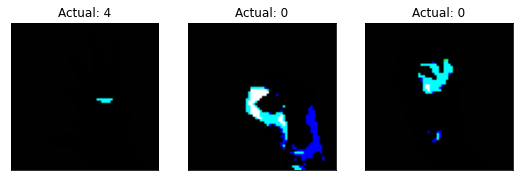

In [10]:
dl_train, dl_val, ds_train, ds_val = get_fold_dls(0, k_folds, train_x, train_y)
#len(ds_val)
show_batch(ds_val, 3, 1, 3)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import timm

class ImageClassificationModel(nn.Module):
    @staticmethod
    def get_backbone_classifier(model_to_use, drop_out, num_classes):
        pt_model = timm.create_model(model_to_use, pretrained=True)
        backbone = None
        classifier = None
        if model_to_use in [Models.RESNET34, Models.RESNET50, Models.RESNEXT50]:            
            backbone = nn.Sequential(*list(pt_model.children())[:-1])
            in_features = pt_model.fc.in_features
            classifier = nn.Sequential(
                nn.Dropout(drop_out),
                nn.Linear(in_features, num_classes)
            )    
        return backbone, classifier

    def __init__(self, num_classes, drop_out=0.25, model_to_use="resnext"):
        super().__init__()                
        self.num_classes = num_classes        
        self.backbone, self.classifier = self.get_backbone_classifier(model_to_use, drop_out, num_classes)    

    def forward(self, x):
        features = self.backbone(x)
        features = torch.flatten(features, 1)                
        x = self.classifier(features)
        return x

In [12]:
import torchmetrics
from torch.nn.functional import cross_entropy
from torchmetrics.functional import accuracy

class ImageClassificationLitModel(pl.LightningModule):
    def __init__(self, num_classes, hparams, model_to_use):
        super().__init__()
        self.save_hyperparameters()
        #self.hparams = hparams
        #self.model = ImageClassificationModel(num_classes, hparams["drop_out"], model_to_use)
        self.lr = hparams["lr"]
        self.num_classes = num_classes        
        self.backbone, self.classifier = self.get_backbone_classifier(model_to_use, hparams["drop_out"], num_classes) 
        #self.loss_fn = F.cross_entropy
        #self.train_metric = torchmetrics.Accuracy()
        #self.val_metric = torchmetrics.Accuracy()

    @staticmethod
    def get_backbone_classifier(model_to_use, drop_out, num_classes):
        pt_model = timm.create_model(model_to_use, pretrained=True)
        backbone = None
        classifier = None
        if model_to_use in [Models.RESNET34, Models.RESNET50, Models.RESNEXT50]:            
            backbone = nn.Sequential(*list(pt_model.children())[:-1])
            in_features = pt_model.fc.in_features
            classifier = nn.Sequential(
                nn.Dropout(drop_out),
                nn.Linear(in_features, num_classes)
            )    
        return backbone, classifier

    def forward(self, x):
        features = self.backbone(x)
        features = torch.flatten(features, 1)                
        x = self.classifier(features)
        return x

    def configure_optimizers(self):
        model_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.lr)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer, "min")        
        return {
            "optimizer": model_optimizer, 
            "lr_scheduler": {
                "scheduler": lr_scheduler,
                "monitor": "val_loss",
                "frequency": 1
            }
        }

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self(X)
        loss = cross_entropy(y_pred, y)
        acc = accuracy(y_pred, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("train_accuracy", acc, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        return loss        

    # def training_epoch_end(self, outputs):
    #     train_epoch_acc = self.train_metric.compute()
    #     self.log("train_accuracy", train_epoch_acc, on_step=False, on_epoch=False, logger=True, prog_bar=True)        

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self(X)
        val_loss = cross_entropy(y_pred, y)
        val_acc = accuracy(y_pred, y)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("val_accuracy", val_acc, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        return val_loss                
        

In [13]:
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping

# For results reproducibility 
# sets seeds for numpy, torch, python.random and PYTHONHASHSEED.
pl.seed_everything(42, workers=True)
multiplicative = lambda epoch: 1.5
backbone_finetuning = BackboneFinetuning(Config.UNFREEZE_EPOCH_NO, multiplicative, verbose=False)
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=5, mode="min")

# model hyperparameters
model_params = {    
    "drop_out": 0.25,
    "lr": 0.000366
    }

Global seed set to 42


In [14]:
from optuna.integration import PyTorchLightningPruningCallback

def run_hparam_tuning(model_params, trial):
    dl_train, dl_val, ds_train, ds_val = get_fold_dls(0, k_folds, train_x, train_y)    
    early_stopping = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    backbone_finetuning_cb = BackboneFinetuning(Config.UNFREEZE_EPOCH_NO, multiplicative, verbose=False)
    signs_model = ImageClassificationLitModel(
        num_classes=Config.NUM_CLASSES, 
        hparams=model_params,        
        model_to_use=Models.RESNET50
        )  
    trainer = pl.Trainer(
        checkpoint_callback=False,        
        gpus=1,
        # For results reproducibility 
        deterministic=True,
        auto_select_gpus=True,
        progress_bar_refresh_rate=20,
        max_epochs=Config.NUM_EPOCHS,        
        #precision=Config.PRECISION,   
        weights_summary=None,                     
        callbacks=[backbone_finetuning_cb, early_stopping]
    )      
    trainer.fit(signs_model, train_dataloaders=dl_train, val_dataloaders=dl_val)     
    loss = trainer.callback_metrics["val_loss"].item()
    del trainer, signs_model, early_stopping, backbone_finetuning_cb, dl_train, dl_val
    return loss

In [15]:
def run_training(dl_train, dl_val, model_params, fold=None):    
    fold_str = f"fold_{fold}"
    tb_logger = None
    chkpt_file_name = "best_model_{epoch}_{val_loss:.4f}"
    if fold:       
        chkpt_file_name = fold_str + "_" + chkpt_file_name
        tb_logger = pl.loggers.TensorBoardLogger(save_dir="logs", version=fold_str)
    else:
        tb_logger = pl.loggers.TensorBoardLogger(save_dir="logs")        
    signs_model = ImageClassificationLitModel(
        num_classes=Config.NUM_CLASSES, 
        hparams=model_params,        
        model_to_use=Models.RESNET50
        )    
    checkpoint_callback = ModelCheckpoint(
        dirpath="./model", 
        verbose=True,
        monitor="val_loss", 
        filename=chkpt_file_name
        )
    trainer = pl.Trainer(
        gpus=1,
        # For results reproducibility 
        deterministic=True,
        auto_select_gpus=True,
        progress_bar_refresh_rate=20,
        max_epochs=Config.NUM_EPOCHS,
        logger=tb_logger,
        auto_lr_find=True,    
        precision=Config.PRECISION,                        
        callbacks=[checkpoint_callback, backbone_finetuning, early_stopping_callback]
    )
    trainer.tune(model=signs_model, train_dataloaders=dl_train)
    print(signs_model.lr)
    trainer.fit(signs_model, train_dataloaders=dl_train, val_dataloaders=dl_val)                
    del trainer, signs_model        
    

In [16]:
import optuna

def objective(trial):
    params = {
        "lr": trial.suggest_loguniform("lr", 1e-6, 1e-3),
        "drop_out": trial.suggest_uniform("drop_out", 0.2, 0.7)
    }    
    loss = run_hparam_tuning(params, trial)
    return loss

study = optuna.create_study(direction="minimize", study_name="SignsImageClassificationTuning")    
study.optimize(objective, n_trials=10)
print(f"Best trial number = {study.best_trial.number}")
print("Best trial params:")
print(study.best_params)

[I 2021-12-06 16:56:52,374] A new study created in memory with name: SignsImageClassificationTuning
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42
/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Validating: 0it [00:00, ?it/s]

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/callbacks/finetuning.py:215: UserWarning: The provided params to be freezed already exist within another group of this optimizer. Those parameters will be skipped.
HINT: Did you init your optimizer in `configure_optimizer` as such:
 <class 'torch.optim.adam.Adam'>(filter(lambda p: p.requires_grad, self.parameters()), ...) 
  rank_zero_warn(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2021-12-06 16:57:47,145] Trial 0 finished with value: 1.6497912406921387 and parameters: {'lr': 2.396872355565215e-05, 'drop_out': 0.24835950368566706}. Best is trial 0 with value: 1.6497912406921387.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42
/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Validating: 0it [00:00, ?it/s]

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/callbacks/finetuning.py:215: UserWarning: The provided params to be freezed already exist within another group of this optimizer. Those parameters will be skipped.
HINT: Did you init your optimizer in `configure_optimizer` as such:
 <class 'torch.optim.adam.Adam'>(filter(lambda p: p.requires_grad, self.parameters()), ...) 
  rank_zero_warn(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2021-12-06 16:58:09,051] Trial 1 finished with value: 1.7835029363632202 and parameters: {'lr': 1.0695253191625282e-06, 'drop_out': 0.2900737902439996}. Best is trial 0 with value: 1.6497912406921387.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42
/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Validating: 0it [00:00, ?it/s]

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/callbacks/finetuning.py:215: UserWarning: The provided params to be freezed already exist within another group of this optimizer. Those parameters will be skipped.
HINT: Did you init your optimizer in `configure_optimizer` as such:
 <class 'torch.optim.adam.Adam'>(filter(lambda p: p.requires_grad, self.parameters()), ...) 
  rank_zero_warn(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2021-12-06 16:58:31,722] Trial 2 finished with value: 1.7841163873672485 and parameters: {'lr': 1.388434476177339e-06, 'drop_out': 0.6874952343519483}. Best is trial 0 with value: 1.6497912406921387.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42
/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Validating: 0it [00:00, ?it/s]

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/callbacks/finetuning.py:215: UserWarning: The provided params to be freezed already exist within another group of this optimizer. Those parameters will be skipped.
HINT: Did you init your optimizer in `configure_optimizer` as such:
 <class 'torch.optim.adam.Adam'>(filter(lambda p: p.requires_grad, self.parameters()), ...) 
  rank_zero_warn(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2021-12-06 16:58:53,501] Trial 3 finished with value: 1.5186837911605835 and parameters: {'lr': 4.666226617212337e-05, 'drop_out': 0.5927884172090065}. Best is trial 3 with value: 1.5186837911605835.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42
/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Validating: 0it [00:00, ?it/s]

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/callbacks/finetuning.py:215: UserWarning: The provided params to be freezed already exist within another group of this optimizer. Those parameters will be skipped.
HINT: Did you init your optimizer in `configure_optimizer` as such:
 <class 'torch.optim.adam.Adam'>(filter(lambda p: p.requires_grad, self.parameters()), ...) 
  rank_zero_warn(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2021-12-06 16:59:19,118] Trial 4 finished with value: 0.11135455220937729 and parameters: {'lr': 0.0005896240467079943, 'drop_out': 0.43380930185619204}. Best is trial 4 with value: 0.11135455220937729.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42
/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Validating: 0it [00:00, ?it/s]

[I 2021-12-06 16:59:28,032] Trial 5 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42
/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Validating: 0it [00:00, ?it/s]

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/callbacks/finetuning.py:215: UserWarning: The provided params to be freezed already exist within another group of this optimizer. Those parameters will be skipped.
HINT: Did you init your optimizer in `configure_optimizer` as such:
 <class 'torch.optim.adam.Adam'>(filter(lambda p: p.requires_grad, self.parameters()), ...) 
  rank_zero_warn(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2021-12-06 16:59:53,791] Trial 6 finished with value: 0.07401841133832932 and parameters: {'lr': 0.0005820366967361859, 'drop_out': 0.37767452978132954}. Best is trial 6 with value: 0.07401841133832932.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

[W 2021-12-06 16:59:58,871] Trial 7 failed because of the following error: OSError(12, 'Cannot allocate memory')
Traceback (most recent call last):
  File "/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8572/2619865954.py", line 9, in objective
    loss = run_hparam_tuning(dl_train, dl_val, params, trial)
  File "/tmp/ipykernel_8572/448376423.py", line 23, in run_hparam_tuning
    trainer.fit(signs_model, train_dataloaders=dl_train, val_dataloaders=dl_val)
  File "/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 552, in fit
    self._run(model)
  File "/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 922, in _run
    self._dispatch()
  File "/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.

OSError: [Errno 12] Cannot allocate memory

In [ ]:
# for fold in range(Config.NUM_FOLDS):
#     dl_train, dl_val, ds_train, ds_val = get_fold_dls(fold, k_folds, train_x, train_y)
#     run_training(dl_train, dl_val, model_params, fold)